In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym[atari]
!pip install pyvirtualdisplay
!conda install piglet
!pip install pystan
!conda install swig
!pip install box2d-py
!pip install gym[Box_2D]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 59 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 0s (5,439 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 144328 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Th

In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [4]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

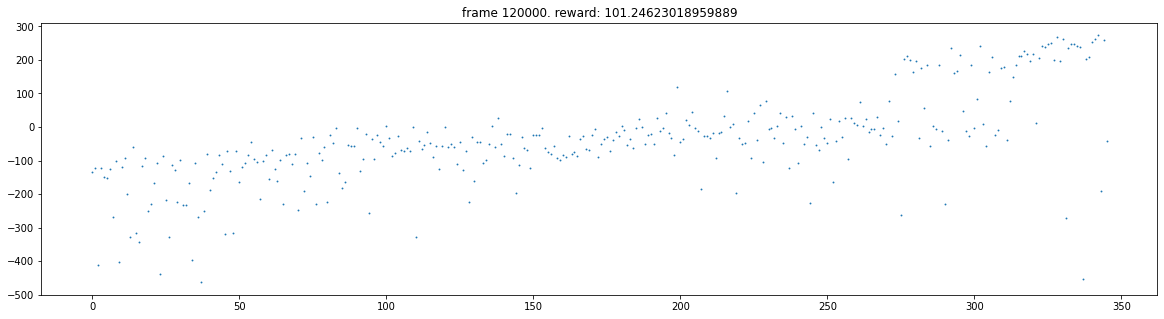

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
import math, random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
from collections import deque
from IPython.display import clear_output
import matplotlib.pyplot as plt
from google.colab import files
get_ipython().run_line_magic('matplotlib', 'inline')


#!pip install gym[LunarLander]
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def __len__(self):
        return len(self.buffer)

    def push(self, state, action, reward, next_state, done):
        '''Add new samples to replay buffer'''
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)
        # record the dimension of the state
        self.state_dim = state
    
    def sample(self, batch_size):
        ''' sample a batch uniformly from replay buffer, sample without replacement.
            Return a tuple (state_batch, action_batch, reward_batch, next_state_batch, done_batch), where
            state_batch, next_state_batch: 2D array, [batch_size,state_dim]
            action_batch, reward_batch, done_batch: 1D array [batch_size]
            Note : the order in these arrays must be matched. 
            i.e. state_batch = [S_1,S_2,S_3,...S_n]
                 action_batch = [a_1,a_2,a_3....a_n] , n = batch_size, the same for the rest three batches
            Useful function: np.empty() for initializing N-dim array
                            random.sample() for sampling without replacement
        '''

        # first initialize
        #state_batch = np.empty([batch_size,state_d])
        #action_batch = np.empty([batch_size])
        #reward_batch = np.empty([batch_size])
        #next_state_batch = np.empty([batch_size,state_d])
        #done_batch = np.empty([batch_size])

        # Take #batch_size samples from the replay buffer and write into different arrays.
        index = np.random.choice(len(self.buffer), batch_size, replace = False)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*[self.buffer[idx] for idx in index])
        
        #return np.concatenate(state_batch), np.array(action_batch), np.array(reward_batch) , np.concatenate(next_state_batch), np.array(done_batch)
        return np.array(state_batch), np.array(action_batch), np.array(reward_batch) , np.array(next_state_batch), np.array(done_batch)




class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()  
        ''' To Do: Create the following network architecture:
            (1) The first input layer, a fully connected (FC) layer with (input_dim*128), followed by a PReLU layer, see literature for how PRelu works
            (2) A hidden layer, also FC, 128*64, and followed by PRELU
            (3) The output layer, FC layer, (64*number_of_actions) , no activations, as the output approximates the q(s,a)
            Useful function: nn.Sequential() , nn.Linear(), nn.PReLU()
        '''
        self.layers = torch.nn.Sequential(
                        torch.nn.Linear(num_inputs, 128),
                        torch.nn.PReLU(),
                        torch.nn.Linear(128,64),
                        torch.nn.PReLU(),
                        torch.nn.Linear(64, num_actions))
        
        
    def forward(self, x):
        ''' Retrieve the approximated q(s,a) for the given input x=(s,a)
        '''
        return self.layers(x)
    
    def act(self, state, epsilon):
        ''' TODO: Perform epislon greedy exploration strategy here,
            Return : action index in discrete action space, type(action) = int
            You will need to call the function: self.forward(state)
        '''
        state = torch.FloatTensor(np.float32(state)).to(device)
        #print(state.shape)
        if np.random.random() <= epsilon:
          with torch.no_grad():
            action = random.randrange(env.action_space.n)
            #action = int(action)
        else: 
          with torch.no_grad():
            #state   = torch.FloatTensor(state).unsqueeze(0)
            q_value = self.forward(state)
            #print(q_value)
            #print('shape of the q_value')
            #print(q_value.shape)
            #action = torch.max(q_value, 1)[1].data.numpy()
            #action = action[0] if state == 0 else action.reshape(state)
            #action = q_value.max(1)[1].data[0]
            action = np.argmax(q_value.cpu())
            action = int(action) # not really necessary
             
        return action

    def test_act(self, state):
        ''' To Do: Perform greedy action for the current state for the testing phase
            Return : action index in discrete action space, type(action) = int
            You will need to call the function: self.forward(state)
        '''
        state = torch.FloatTensor(np.float32(state)).to(device)
        with torch.no_grad():
          q_value = self.forward(state)
          #print(q_value)
          action = np.argmax(q_value.cpu())
          action = int(action)
        
        return action

def polyak_update(polyak_factor, target_network, network):
    for target_param, param in zip(target_network.parameters(), network.parameters()):
        target_param.data.copy_(polyak_factor*param.data + target_param.data*(1.0 - polyak_factor))

def compute_td_loss(batch_size, replay_buffer, optimizer, device, model, model_target, gamma, task):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    state      = torch.FloatTensor(np.float32(state)).to(device)
    next_state = torch.FloatTensor(np.float32(next_state)).to(device)
    action     = torch.LongTensor(action).to(device)
    reward     = torch.FloatTensor(reward).to(device)
    done       = torch.FloatTensor(done).to(device)

    '''TODO : Implement the DQN/ DDQN algorithm update rule here 
    You need to define the loss metric as Mean Square Error. 
    The difference between DQN & DDQN is shown in these steps.
    Useful function: in-place operations on tensors 'tensor_a.gather()' , 'tensor_b.unsqueeze()', 'tensor_x.squeeze()' , 'tensor.max()'
    with torch.no_grad() ,  .detach()
    '''
    if task == 1:
      q_values = model(state)#.cuda()
      next_q_values = model_target(next_state)#.cuda()
      q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
      next_q_value     = next_q_values.max(1)[0]
      # Q(s,a;theta) = R + gamma * max(Q(s',a';theta^{-}))
      expected_q_value = reward + gamma * next_q_value * (1 - done)
    else: 
      # helpful: https://github.com/higgsfield/RL-Adventure/blob/master/2.double%20dqn.ipynb
      q_values = model(state)
      next_q_values = model(next_state)
      next_q_state_values = model_target(next_state)

      q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
      next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
      expected_q_value = reward + gamma * next_q_value * (1- done)
      
    #loss = torch.nn.MSELoss()
    #loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
    crit = torch.nn.MSELoss()
    loss = crit(q_value, expected_q_value)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Perform soft update (Polyak averaging) with tau = 0.005
    # Refer to the post from Navneet_M_Kumar under https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/16 for answer    
    tau = 0.005
    model_target = polyak_update(tau, model_target, model)
    
    return loss


def test(env, model):       
    ''' 
        Testing phase.
        Only for local users, you can add env.render()
    '''
    state = env.reset()
    episode_reward = 0
    # Limit the maximal episode length to avoid infinite loop
    for t in range(1000): 
        action = model.test_act(state)
        next_state, reward, done, _ = env.step(action)    
        #env.render()        
        state = next_state
        episode_reward += reward
        if done == True:                  
            print("test reward : {}".format(episode_reward))
            break


def plot(frame_idx, rewards, losses, task):
    '''
        For monitoring the training process
    '''
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    if task == 1:
        plt.plot(rewards)
    elif task == 2:
        plt.scatter(np.linspace(0,len(rewards)-1,len(rewards)),rewards, s=0.75)
    plt.subplot(122)
    plt.title('loss')
    plt.plot(losses)
    plt.show()



if __name__ == "__main__":    
    '''
        Important: The maximal number of interactions: num_frames = 1000000,
        But it is definitely NOT NECESSARY to ran until the end.
        If the training episodic reward already reaches >-200, then you can STOP the program.
        It takes roughly 10 minutes to get converged to episodic reward >-200 in Colab. 
        You need to write code to save the statistics at the last line of the program.       
    '''
    task = 2 # to modify
    if task == 1:
        env = gym.make('MountainCar-v0').env # the suffix .env removes the constraint of maximal episodic length of 200 steps 
    elif task == 2:
        env = gym.make('LunarLander-v2') # An episode will be forced to terminate after 1000 steps in this env setting.
    print(env.observation_space, env.action_space)   #observation_space and action space
    
    # Initialize the exploration strategy/coefficient
    epsilon_start = 1.0
    epsilon_final = 0.05 # to ensure sufficient exploration 
    epsilon_decay = 30000 
    epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)  
    # Plot the exploration rate w.r.t. number of steps (frame_index) the agent has traversed. 
    plt.plot([epsilon_by_frame(i) for i in range(100000)])
    
    # Initialize the Deep Q-networks
    model = DQN(env.observation_space.shape[0], env.action_space.n)
    # Declare target network, initialize it 
    model_target = DQN(env.observation_space.shape[0], env.action_space.n)
    
    # -->TODO: Copy the weights from model to model_target using 'load_state_dict'
    model_target.load_state_dict(model.state_dict())
    
    # Put networks to GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model_target = model_target.to(device)
    #Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda()
    
    # Initialize the optimizer for learning the weights of Neural Network
    optimizer = optim.Adam(model.parameters(), lr = 0.001)    
    if task == 1:
        batch_size = 32
        test_every_N_training_episode = 4
        start_train = 1000
    elif task == 2:
        batch_size = 128
        test_every_N_training_episode = 10
        # Only start training when there is a sufficient number of experience stored in replay buffer
        start_train = 3000 
    # Initialize the replay buffer with the maximal storage of 1000000 experience/interactions
    replay_buffer = ReplayBuffer(1000000)    

    gamma = 0.99 # discount factor

    # Statistics 
    losses = []
    all_rewards = []
    episode_reward = 0
    episode_count = 0
    episodic_step_count = 0
    
    
    #---------------------Training----------------------
    num_frames = 1000000 # maximal number of interactions, similar to N_episodes in previous assignments 
    state = env.reset()
    for frame_idx in range(1, num_frames + 1):
        # determine the exploration rate for this step
        epsilon = epsilon_by_frame(frame_idx)
        # Take an action according to exploration strategy
        action = model.act(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        episodic_step_count += 1
        # Add the experience to the replay buffer
        if task == 1:
            replay_buffer.push(state, action, reward, next_state, done)       
        elif task == 2:
            # If terminate due to reaching max epi length, we put done as False to replay buffer so to allow bootstrapping of next successor state
            if episodic_step_count == env._max_episode_steps:  
                replay_buffer.push(state, action, reward, next_state, False)
            else:
                replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward

        
        
        if done:
            all_rewards.append(episode_reward)
            print("Episode#:{} reward:{} eps:{}".format(episode_count,
                                     episode_reward, epsilon))
            episode_reward = 0
            episode_count += 1
            episodic_step_count = 0
            # ---------------------Test Phase--------------------
            if len(all_rewards)%test_every_N_training_episode == test_every_N_training_episode-1:
                test(env, model)
            #----------------------------------------------
            state = env.reset()
            
            
        # Ensure there are enough samples in the replay buffer, then start training the network    
        if len(replay_buffer) > start_train:
            loss = compute_td_loss(batch_size, replay_buffer, optimizer, device, model, model_target, gamma, task)
            losses.append(loss.data)
        
            
        if frame_idx % 1000 == 0:
            savePic = plot(frame_idx, all_rewards, losses, task)
            # --> TODO: You can save the statistics here
            # You could first convert all_rewards and losses into np.array, and save as .npy.file
            if frame_idx == 120000:
              clear_output(True)
              f = plt.figure(figsize=(20,5))
              _ = plt.title('frame %s. reward: %s' % (frame_idx, np.mean(all_rewards[-10:])))
              if task == 1: 
                _ = plt.plot(all_rewards)
              else:
                _ = plt.scatter(np.linspace(0,len(all_rewards)-1,len(all_rewards)),all_rewards, s=0.75)
              _ = plt.show()

              f.savefig('Lakshith_task2.pdf')
              files.download('Lakshith_task2.pdf')
              break
            